In [1]:
import pyemma
# comment
pyemma.__version__

u'2.2.7'

In [2]:
import os
%pylab inline
matplotlib.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import glob
import matplotlib.pyplot as plt

### Read the file list of the trajectories

In [4]:
indir = '/sc/orga/projects/filizm02a/Yi/19_GoITG/108_CCgau_batch/z_ana'
filelist = []
# 10 runs have about 250 ns of MD simulation, the other runs are too short.
for  run in range(20)  :
    filelist.append("%s/T140_13_CCd_2_5_sg0.15_r%2.2i.10ps.fitted.xtc"%(indir,run))
name = "T140_13_20run_sg0.15"
print("%d trajectories in list"%len(filelist))

20 trajectories in list


### Define the cys-cys distances and RMSD as features

In [54]:
feat = coor.featurizer('itg_close.pdb')
feat.add_minrmsd_to_ref('itg_close.pdb')
feat.add_minrmsd_to_ref('itg_itmd2.pdb')
feat.add_minrmsd_to_ref('itg_close.pdb',
                        atom_indices=np.array(
        list(range(1347,1429)) + 
        list(range(1105,1346))
    ))

feat.dimension()


dir="/sc/orga/projects/filizm02a/Yi/19_GoITG/103_gauRedo/"
pairs_allost=np.loadtxt(dir+"3FCS_CC_allo.txt").astype('int')-1
pairs_struct=np.loadtxt(dir+"3FCS_CC_stru.txt").astype('int')-1

feat.add_distances(pairs_allost)
feat.add_distances(pairs_struct)


In [55]:
feat2 = coor.featurizer('itg_close.pdb')
headpiece = np.array(list(range(1,450)) + list(range(1111,1350)) )
feat2.add_minrmsd_to_ref('itg_close.pdb',atom_indices=np.array(range(1,450)))
inp2 = coor.source(filelist, feat2)
data1b =inp2.get_output()

In [56]:
data1b_stack = np.concatenate(data1b)

In [57]:
## labels and indices for the contacts
desc_struct=[str(pairs_struct[i,:]) for i in range(len(pairs_struct))]
desc_allos=[str(pairs_allost[i,:]) for i in range(len(pairs_allost))]

In [58]:
inp = coor.source(filelist, feat)
data1=inp.get_output()

In [59]:
## define new CVs (a path variable: 0->closed, 1->intermediateII)

def add_path(cvtraj):
    lam = 0.6
    s1=np.exp(-cvtraj[:,1]*lam)/(np.exp(-cvtraj[:,0]*lam)+np.exp(-cvtraj[:,1]*lam))
    s2=np.exp(-cvtraj[:,2]*lam)/(np.exp(-cvtraj[:,0]*lam)+np.exp(-cvtraj[:,2]*lam))
    z1=-1/lam*np.log((np.exp(-cvtraj[:,0]*lam)+np.exp(-cvtraj[:,1]*lam)))

    return np.concatenate((s1[:,None],z1[:,None],s2[:,None],cvtraj),axis=1)

data2 = list(map(add_path, data1))
data2_stack = np.vstack(data2)
## we have 3cv (0:path1s, 1:path1z, 2:path2, 3:RMSD1, 4:RMSD2, 5:RMDS3) before the contacts
cv_offset = 6

In [60]:
index_allost=range(len(pairs_allost))
index_struct=range(len(pairs_allost),len(pairs_allost)+len(pairs_struct))

In [61]:
## define a switch function (1-> contact formed, 0->contact broken)
def switch_function(dist):
    if(False):
        sigma=((dist-.6)/.2)
        y=(1-sigma**10)/(1-sigma**12)
        y[dist<.6]=1
    else:
        sigma=dist/.8
        y=(1-sigma**8)/(1-sigma**10)
    return y

## Plot cys-cys bonds for Allosteric bridges

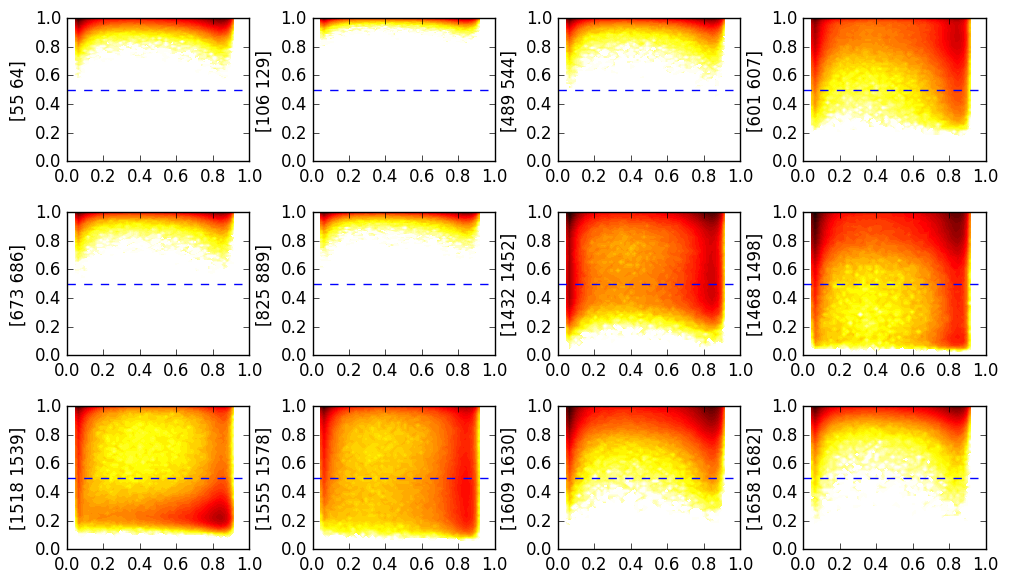

In [62]:
f, axarr = plt.subplots(3, 4,figsize=(10,3*2))
f.tight_layout()

bonds=index_allost
for i,ax in enumerate(axarr.ravel()):
    if(i<len(bonds)):
        bond=bonds[i]+cv_offset
        contact = switch_function(data2_stack[:,bond])
        z,x,y = np.histogram2d(data2_stack[:,0],contact , bins=50)
        # compute free energies
        with numpy.errstate(divide='ignore'):
            F = -np.log(z)        
        extent = [x[0], x[-1], y[0], y[-1]]
        ax.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent, extend='both')
        ax.set_ylim([0,1])
        ax.set_xlim([0,1])
        ax.set_ylabel(desc_allos[i])
        ax.axhline(y=.5, xmin=0, xmax=1, linewidth=1, color='b', linestyle='dashed' )
    else:
        ## remove box
        ax.axis('off')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


plt.show()

on x-axis progression from close (x=0) to intermediate II (x=1), on y-axis bond formed (y=1) vs. bond broken (y=0)

## Plot cys-cys bonds for Strcutural bridges

In [ ]:
pairs_struct
#np.array(index_struct)+5

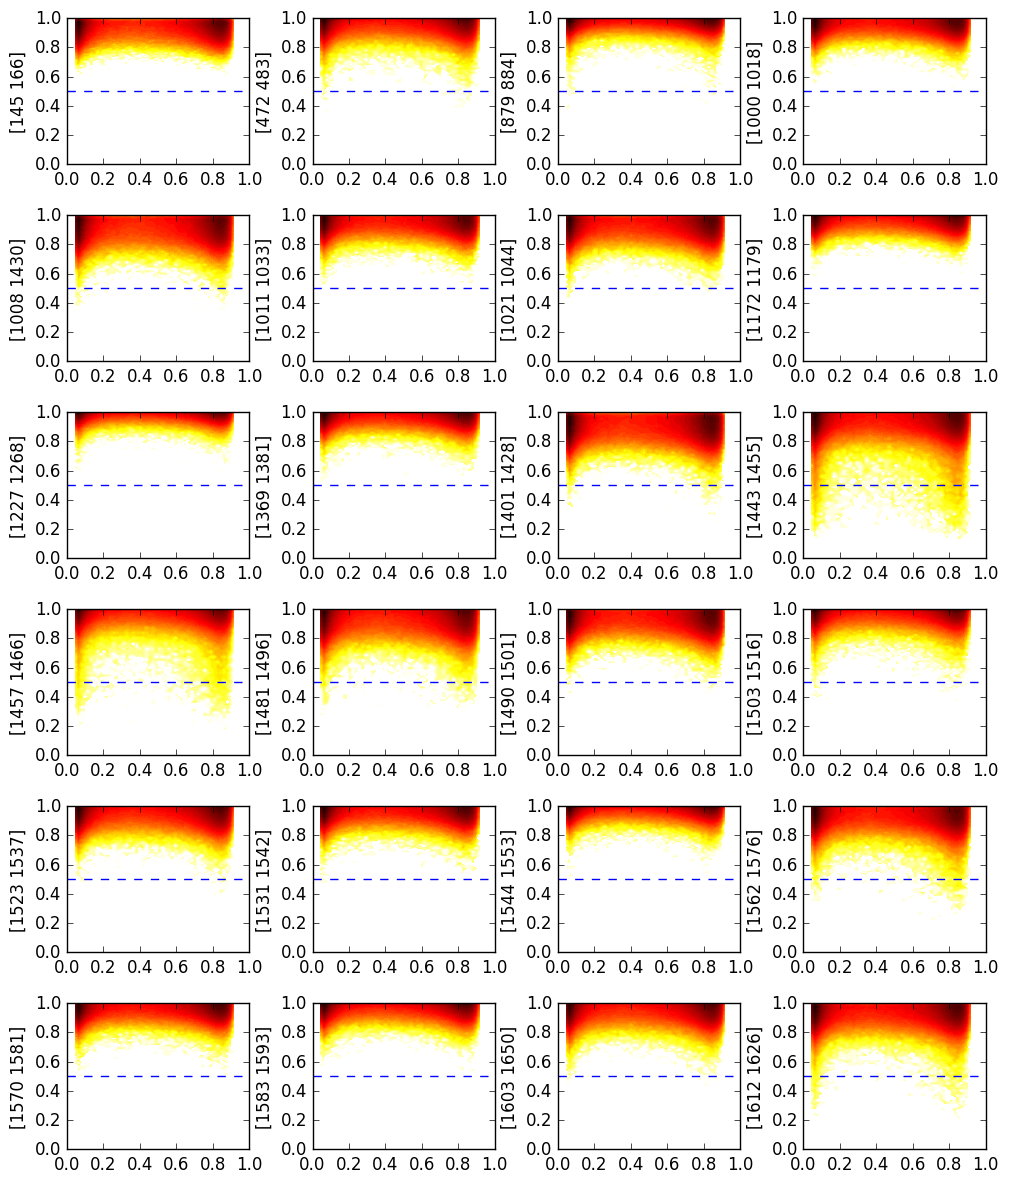

In [63]:
f, axarr = plt.subplots(6, 4,figsize=(10,6*2))
f.tight_layout()

bonds=index_struct
for i,ax in enumerate(axarr.ravel()):
    if(i<len(bonds)):
        bond=bonds[i]+cv_offset
        contact = switch_function(data2_stack[:,bond])
        z,x,y = np.histogram2d(data2_stack[:,0],contact , bins=50)
        # compute free energies
        with numpy.errstate(divide='ignore'):
            F = -np.log(z)
        extent = [x[0], x[-1], y[0], y[-1]]
        #extent = [-1, 1.5, -.5, 1.5]
        ax.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent, extend='both')
        ax.set_ylim([0,1])
        ax.set_xlim([0,1])
        ax.set_ylabel(desc_struct[i])
        ax.axhline(y=.5, xmin=0, xmax=1, linewidth=1, color='b', linestyle='dashed' )

    else:
        ## remove box
        ax.axis('off')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.show()

on x-axis progression from close (x=0) to intermediate II (x=1), on y-axis bond formed (y=1) vs. bond broken (y=0)

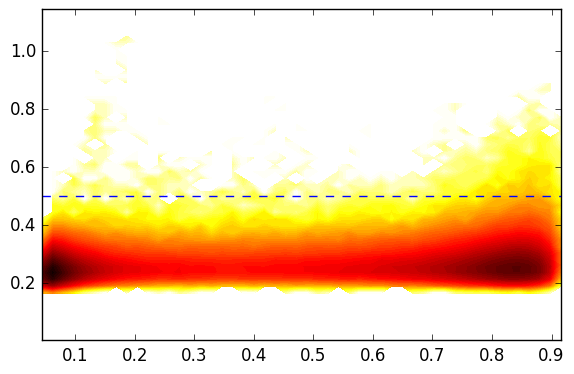

In [64]:
f, ax = plt.subplots(1, 1,figsize=(6,4))
f.tight_layout()

z,x,y = np.histogram2d(data2_stack[:,0],data2_stack[:,5] , bins=50)
# compute free energies
with numpy.errstate(divide='ignore'):
    F = -np.log(z)
extent = [x[0], x[-1], y[0], y[-1]]
#extent = [-1, 1.5, -.5, 1.5]
ax.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent, extend='both')
#ax.set_ylim([0,1])
#ax.set_xlim([0,1])

ax.axhline(y=.5, xmin=0, xmax=1, linewidth=1, color='b', linestyle='dashed' )


### tICA and free-energy convergence

In [59]:
feat3 = coor.featurizer('itg_close.pdb')
feat3.add_distances(indices=list(range(1,1700,15)))
inp3 = coor.source(filelist, feat3, stride=100)

03-05-17 19:26:44 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[9] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


2017-05-03 19:26:44,751 - pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[9] - WARNING - The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features


In [60]:
feat3.dimension()

6441

In [61]:
tica_obj = coor.tica(inp3,stride=100,lag=10)
# Y = tica_obj.get_output()

In [62]:
Y = tica_obj.get_output()

In [65]:
Y_stack = np.concatenate(Y)

In [96]:
stop_pts = (np.array([0,.50,.75,1])*Y_stack.shape[0]).astype('int')
stop_pts[3]

465349

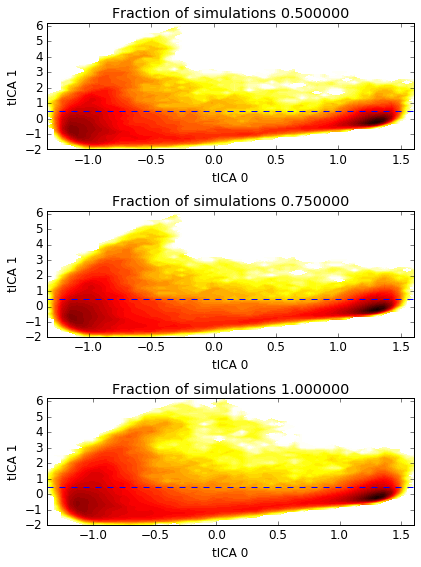

In [110]:
f, axarr = plt.subplots(3, 1,figsize=(3*2,8))

stop_frac = np.array([0,.50,.75,1])
stop_pts = (stop_frac*Y_stack.shape[0]).astype('int')

for i,ax in enumerate(axarr.ravel()):
    z,x,y = np.histogram2d(Y_stack[:stop_pts[i+1],0],
                           Y_stack[:stop_pts[i+1],1] , bins=50)
    # compute free energies
    with numpy.errstate(divide='ignore'):
        F = -np.log(z)        
    extent = [x[0], x[-1], y[0], y[-1]]
    ax.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent, extend='both')
    #ax.set_ylim([0,1])
    #ax.set_xlim([0,1])
    ax.set_ylabel("tICA 1")
    ax.set_xlabel("tICA 0")
    ax.set_title('Fraction of simulations %f'% stop_frac[i+1])
    ax.axhline(y=.5, xmin=0, xmax=1, linewidth=1, color='b', linestyle='dashed' )

f.tight_layout()
plt.show()

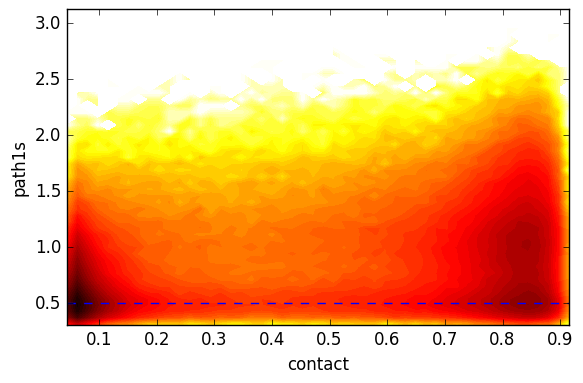

In [93]:
bonds=index_allost
icontact = bonds[9]+cv_offset
f, ax = plt.subplots(1, 1,figsize=(6,4))

z,x,y = np.histogram2d(data2_stack[:,0],
                       data2_stack[:,icontact] , bins=50)
# compute free energies
with numpy.errstate(divide='ignore'):
        F = -np.log(z)        
extent = [x[0], x[-1], y[0], y[-1]]
ax.contourf(F.T, 50, cmap=plt.cm.hot, extent=extent, extend='both')
#ax.set_ylim([0,1])
#ax.set_xlim([0,1])
ax.set_ylabel("path1s")
ax.set_xlabel("contact")
ax.axhline(y=.5, xmin=0, xmax=1, linewidth=1, color='b', linestyle='dashed' )

#it=10
#ax.plot(data2[it][:6000,0],data2[it][:6000,icontact])


f.tight_layout()
plt.show()

### tica 2 analysis

In [112]:
tica_obj.feature_TIC_correlation.shape

(6441, 3393)

In [144]:
correlations1=tica_obj.feature_TIC_correlation[:,1]
cutoff=.55
selected = np.abs(correlations1)>cutoff
pairs=np.array(feat3.describe())[selected]
np.sum(selected)

16

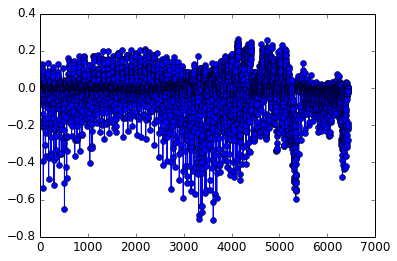

In [142]:
plt.plot(correlations1,marker='o')

In [ ]:
ex=np.vectorize(lambda x: np.array(x.split(' '))[[2,7]])
ex(pairs)

In [164]:
pairs

array(['DIST: GLY 62 CA 61 - PHE 992 CA 991',
       'DIST: PRO 452 CA 451 - PHE 992 CA 991',
       'DIST: VAL 482 CA 481 - PHE 992 CA 991',
       'DIST: ASN 497 CA 496 - PHE 992 CA 991',
       'DIST: ARG 512 CA 511 - LEU 977 CA 976',
       'DIST: ARG 512 CA 511 - PHE 992 CA 991',
       'DIST: ARG 512 CA 511 - MET 1697 CA 1696',
       'DIST: GLN 527 CA 526 - LEU 977 CA 976',
       'DIST: GLN 527 CA 526 - PHE 992 CA 991',
       'DIST: GLN 527 CA 526 - MET 1697 CA 1696',
       'DIST: SER 572 CA 571 - LEU 977 CA 976',
       'DIST: SER 572 CA 571 - PHE 992 CA 991',
       'DIST: SER 572 CA 571 - MET 1697 CA 1696',
       'DIST: HIS 587 CA 586 - PHE 992 CA 991',
       'DIST: PHE 992 CA 991 - ARG 1457 CA 1456',
       'DIST: PHE 992 CA 991 - CYS 1502 CA 1501'], 
      dtype='<U41')

In [161]:
ex(pairs[0])

array(['62', '992'], 
      dtype='<U5')